In [1]:
import sys
import os
from pathlib import Path
path_dcf = str(Path(os.path.abspath('.')).resolve().parent)
sys.path.append(path_dcf)
from algorithms.unsupervised_dcf import DCF
from torch_contour.torch_contour import CleanContours
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from utils import define_contour_init
import torch

/pasteur/appa/homes/ahabis/miniconda3/envs/scribble/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/pasteur/appa/homes/ahabis/miniconda3/envs/scribble/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Choose an image to perform unsupervised DCF

In [2]:
filename = "flower0.jpg"
img = plt.imread(os.path.join(path_dcf,"images_test_unsupervised_dcf", filename))
shape_origin = img.shape
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA).astype(np.int32)
tensor = (torch.tensor(np.moveaxis(img,-1,0)[None])/255).cuda()

### Instantiate DCF Unsupervised

In [3]:
####UNSUPERVISED SEGMENTATION SETUP:
##### SETUP FOR REAL LIFE IMAGES

dcf = DCF(n_epochs = 100,
          learning_rate = 100.,
          clip = 1e-4,
          exponential_decay = 0.999,
          thresh = 1e-4,
          weights = [1,1/2,1/4,1/8,1/16],
          area_force = 0.,
          sigma=1e-10
          )

/pasteur/appa/homes/ahabis/miniconda3/envs/scribble/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Define initial contour and predict

In [4]:
contour_init, mask = define_contour_init(img,center=[250,250], axes = [250,250], angle = 0)
shape = img.shape[:-1]
x = contour_init/np.array(shape)
c = CleanContours()
contour_init = c.interpolate(x,100).clip(0,1)
contour_init = torch.tensor(contour_init)[None,None].cuda()
contours, energy = dcf.predict(tensor,contour_init)

Contour is evolving please wait a few moment...


100%|██████████| 100/100 [00:10<00:00,  9.15it/s]

Contour stopped


### Show the result of the evolution of the contour 

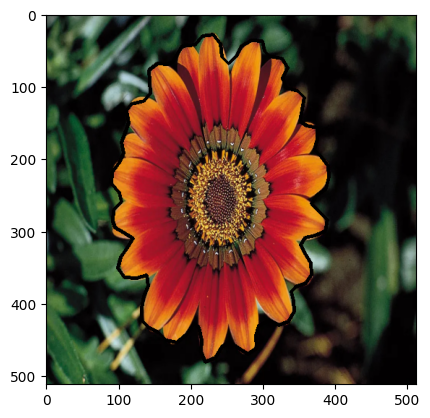

In [5]:
contour_to_display = (np.expand_dims(contours[-1,0,0], 1)).astype(int)
new_img = cv2.drawContours(
    (((img / np.max(img)) * 255).astype(np.uint8)).copy(),
    [contour_to_display],
    0,
    color=1,
    thickness=4,
)

plt.imshow(new_img)
plt.show()

### Save the images of the deformation over time

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap("cool")

colors = [cmap(u)[:-1] for u in np.linspace(0, 1, dcf.n_epochs + 1)]
colors = (np.array(colors) * 255).astype(np.int32).tolist()

tots = []
imgs = []

for i, contour in enumerate(contours):
    contour_to_display = (np.expand_dims(contour, 1)).astype(int)

    new_img = cv2.drawContours(
        (((img / np.max(img)) * 255).astype(np.uint8)).copy(),
        [contour_to_display],
        0,
        color=colors[0],
        thickness=4,
    )
    plt.imsave(
        os.path.join("folder_images_paper", filename.split(".")[0] + str(i) + ".png"),
        new_img,
    )